<a href="https://colab.research.google.com/github/carlos-ochoa/MLPractice/blob/main/RealOrNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Or Not Kaggle competition

This time the task is to find if a tweet is real or not, these tweets are about disasters.

The link of the competition is: https://www.kaggle.com/c/nlp-getting-started/overview


In [ ]:
# First of all I'm gonna load every module that could be useful for this

import pandas as pd
import numpy as np
import re
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import tensorflow.keras as kr
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
import tensorflow_hub as hub

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

We can see the data contained within the csv file. For now, I'm going to use only the text field.

In [ ]:
path = 'drive/My Drive/Competencias Kaggle/RealOrNot/'

train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv') 

display(train_data)

train_dataset = train_data.drop(columns = ['id', 'keyword', 'location'])
test_dataset = test_data.drop(columns = ['keyword', 'location'])

display(train_dataset)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


## Preprocessing text data

There's a proccess I have to follow in order to clean the data, first I'm going to split the words in every sentence, and then erase some special characters.

Then stopwords will be removed and words will be lematized.


In [ ]:
lemmatizer = WordNetLemmatizer()

sentences = list(train_dataset['text'])
sentences_test = list(test_dataset['text'])

def listToString(s):  
    str1 = ""    
    for ele in s:  
        str1 += ele   
    return str1

def hasNumbers(inputString):
  return bool(re.search(r'\d', inputString))

def proccess_text(sentences):
  sent = ''
  final_sentences, f_s = [], []
  # Erasing special characters 
  sentences = [re.sub(r'[^\w]', ' ', sentence) for sentence in sentences]
  # Splitting sentences
  splitted_sentences = [sentence.split() for sentence in sentences]
  # Converting every letter to lowercase and removing stopwords, then lemmatize
  for sentence in splitted_sentences:
    final_sentences.append([lemmatizer.lemmatize(word.lower()) for word in sentence if word.lower() and not word.lower() in stopwords.words('english') and not word.lower().startswith('http') and not hasNumbers(word.lower())])
  for sentence in final_sentences:
    sent = listToString(sentence)
    f_s.append(sent)
  return f_s

final_sentences = proccess_text(sentences)
final_sentences_test = proccess_text(sentences_test)




Time to tokenize! Let's transform every word in a token and then get sequences from that.

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")

def tokenize(final_sentences):
  # fitting the sentences to using created tokenizer object
  tokenizer.fit_on_texts(final_sentences)
  sequences = tokenizer.texts_to_sequences(final_sentences)
  padded_sequences = pad_sequences(sequences, padding = 'post')
  return padded_sequences

training_sequences = tokenize(final_sentences)
training_labels = train_dataset['target']

testing_sequences = tokenize(final_sentences_test)
testing_ids = test_dataset['id']

print(training_sequences.shape)
print(training_labels.shape)

(7613, 23)
(7613,)


## Neural network model

We have a RNN architecture with Bidirectional LSTM units, also I'm using transfer learning in order to vectorize words in useful embeddings trained with 200B words.

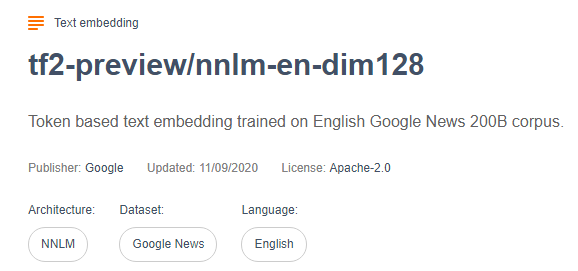

Even though I've coded a preproccesing and tokenizing function, they are not necessary because the nnlm model does preprocessing for me. Nevertheless is a good decisition to do it by myself. 
In fact, I tried these functions to create the proccesed sentences to feed the RNN but its performance wasn't too good, it is better using the preprocessing of the nnlm model itself.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 32)             18560     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              17        
Total params: 124,661,793
Trainable params: 19,105
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/20
90/90 [==============================] - 9s 95ms/step - loss: 0.6480 - accuracy: 0.6873 - 

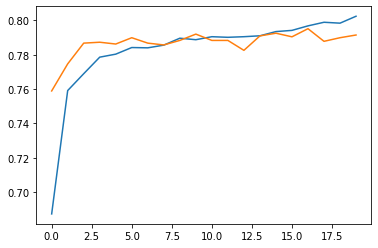

In [ ]:
# Embedding layer, transforms sentences to a 128-dimensional embedding.
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128],
                           input_shape=[], dtype=tf.string)

# creating a model for sentiment analysis
model  = tf.keras.Sequential([
                hub_layer,
                tf.keras.layers.Reshape((1, 128)),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 16, return_sequences=True),input_shape=[1,128]),
                #tf.keras.layers.Dense(15, activation = 'tanh'),
                #tf.keras.layers.Dense(5, activation = 'tanh'),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

num_epochs = 20

history = model.fit(np.array(sentences),training_labels, epochs = num_epochs, verbose = 1, validation_split = 0.25, batch_size=64)

plt.plot(range(num_epochs), history.history['accuracy'])
plt.plot(range(num_epochs), history.history['val_accuracy'])

In [ ]:
predictions = model.predict(np.array(sentences_test))
predictions = np.where(predictions > 0.5, 1, 0)
predictions = predictions.reshape(1,3263).flatten()
results = {'id' : testing_ids, 'target' : predictions.astype('int32')}
results = pd.DataFrame(results)
results.to_csv('results.csv', index = False)
display(results)

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


This is the accuracy achieved.

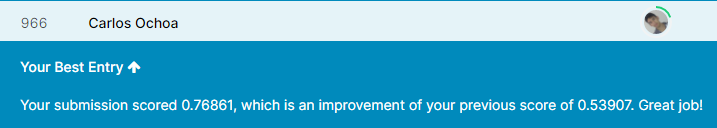

## Results and what I learned

At first my model was suffering of overfitting. That was happening because I was using a custom embedding layer in my RNN, but I didn't have enough data to get a succesful embedding, the vocabulary was pretty small and so the dataset. 

The overfitting was solved using transfer learning for the embedding part.

Nevertheless there was other problem detected: High bias and variance, so even though the RNN gets a good result this is not as good as I wanted. In order to tackle that I've been thinking to get more data. However this could be achieved by data augmentation, something that I will be trying soon.